In [29]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [30]:
import sys
sys.path.insert(0, '../')
from libra import trappist1_all_transits

In [31]:
from astropy.io import fits
from scipy.signal import medfilt

In [32]:
# #f = fits.getdata('/Users/bmmorris/Downloads/nPLDTrappisth2.sc.fits')
# from glob import glob
# import os

# plt.figure()

# for i, path in enumerate(glob('/Users/bmmorris/Downloads/nPLDTrappisth?.sc.fits')):
#     f = fits.getdata(path)

#     time, flux = f['TIME'], f['FLUX']
#     mask = time != 0
#     time += 2454833

#     time = time[mask]
#     flux = flux[mask] / np.median(flux[mask])

#     model = trappist1_all_transits(time)[:, 0]
#     flux /= model

#     p = np.polyfit(time, flux, 2)
#     flux -= np.polyval(p, time)

#     plt.plot(time - time.mean(), flux + 1 + i*0.1, label=os.path.basename(path))
#     plt.ylim([0.9, 1.4])
# plt.legend(loc=(1.05, 0))
# plt.savefig('1hsc.png', dpi=200, bbox_inches='tight')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


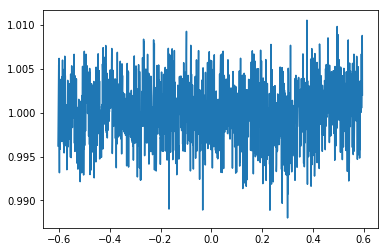

In [39]:
f = fits.getdata('/Users/bmmorris/Downloads/nPLDTrappisth2.sc.fits')

from astropy.stats import mad_std
time, flux = f['TIME'], f['FLUX']
mask = time != 0
time += 2454833

time = time[mask]
flux = flux[mask] / np.median(flux[mask])

model = trappist1_all_transits(time)[:, 0]
flux /= model

mask = (flux < 1.01)
flux = flux[mask]
time = time[mask]
err = mad_std(flux)

p = np.polyfit(time, flux, 2)
flux -= np.polyval(p, time) - 1

plt.plot(time - time.mean(), flux, label=os.path.basename(path))

In [40]:
from interpacf import interpolated_acf

Optimization terminated successfully.
         Current function value: 0.961742
         Iterations: 2
         Function evaluations: 67
Exponential term:  9079.679811472042


/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


(0, 1)

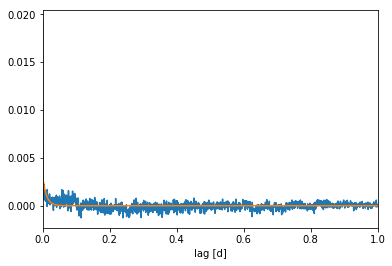

In [75]:
lag, acf = interpolated_acf(time, flux - np.median(flux))

#fig, ax = plt.subplots(1, 2, figsize=(14, 5))

def model(p, lags):
    return np.exp(-lags * p[0])
    
fit_limit = lag < 0.2

def chi2(p, lags): 
    return np.sum((model(p, lags) - acf[fit_limit])**2)

from scipy.optimize import fmin_powell

result = fmin_powell(chi2, [90], args=(lag[fit_limit],))

#plt.plot(x, model([result], x), 'r', lw=2)

print("Exponential term: ", result)

x = np.linspace(lag.min(), lag.max(), 10000)

plt.plot(lag, acf)
plt.plot(x, 0.003 * np.exp(-c * x))# + 0.001 * np.cos(2*np.pi/period * x))
plt.xlabel('lag [d]')
plt.xlim([0, 1])
#ax[0].set_xlim([0, 200])
#ax[0].set_ylim([-0.001, 0.005])
#ax[1].plot(lag * 24 * 60, acf, '.-')

# ax[0].plot(lag * 24 * 60, acf)
# ax[0].plot(x * 24 * 60, 0.003 * np.exp(-c * x))# + 0.001 * np.cos(2*np.pi/period * x))
# ax[0].set_xlabel('lag [min]')
# ax[0].set_xlim([0, 200])
# ax[0].set_ylim([-0.001, 0.005])
# ax[1].plot(lag * 24 * 60, acf, '.-')

# period = 5/60/24

# ax[1].plot(x * 24 * 60, 0.003 * np.exp(-c * x)+ 0.001 * np.cos(2*np.pi/period * x))

# ax[1].set_xlabel('lag [min]')
# ax[1].set_xlim([0, 50])
# ax[1].set_ylim([-0.002, 0.005])

In [76]:
from celerite import terms
import celerite

kernel = terms.JitterTerm(log_sigma=np.log(np.nanmedian(err)))
kernel.freeze_parameter('log_sigma')
kernel += terms.RealTerm(log_a=0, log_c=np.log(result)) 
kernel.freeze_parameter('terms[1]:log_c')

gp = celerite.GP(kernel, mean=1, fit_white_noise=True, fit_mean=True)
gp.compute(time)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

from scipy.optimize import minimize

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(flux, gp))
gp.set_parameter_vector(soln.x)
print(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

[-26.88111923   1.        ]
Final log-likelihood: 7460.162105635027


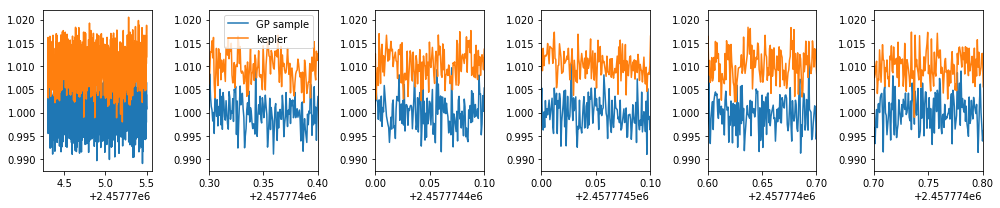

In [77]:
fake_lc = gp.sample()

fake_lc -= np.polyval(np.polyfit(time-time.mean(), fake_lc, 2), time-time.mean()) - 1 

fig, ax = plt.subplots(1, 6, figsize=(14, 3))#, sharey=True)
ax[0].plot(time, fake_lc, label='GP sample')
ax[0].plot(time, flux + 0.01, label='kepler')

ax[1].plot(time, fake_lc, label='GP sample')
ax[1].plot(time, flux + 0.01, label='kepler')
ax[1].set_xlim([time.min()+0, time.min()+0.1])

ax[2].plot(time, fake_lc, label='GP sample')
ax[2].plot(time, flux + 0.01, label='kepler')
ax[2].set_xlim([time.min()+0.1, time.min()+0.20])

ax[3].plot(time, fake_lc, label='GP sample')
ax[3].plot(time, flux + 0.01, label='kepler')
ax[3].set_xlim([time.min()+0.20, time.min()+0.30])

ax[4].plot(time, fake_lc, label='GP sample')
ax[4].plot(time, flux + 0.01, label='kepler')
ax[4].set_xlim([time.min()+0.30, time.min()+0.40])

ax[5].plot(time, fake_lc, label='GP sample')
ax[5].plot(time, flux + 0.01, label='kepler')
ax[5].set_xlim([time.min()+0.40, time.min()+0.50])

ax[1].legend()
fig.tight_layout()
fig.savefig('trappistsc_gp_sample.png', dpi=200, bbox_inches='tight')

In [78]:
import astropy.units as u
from astropy.modeling.blackbody import blackbody_lambda
wavelengths = np.linspace(0.1, 10, 10000) * u.um

kepler_wavelength, kepler_trans = np.loadtxt('../libra/data/filters/kepler_response_hires1.txt', unpack=True)
kepler_wavelength /= 1000
nirspec_wavelength, nirspec_trans = np.loadtxt('../libra/data/etc/NIRSpec_S1600_prism_clear_throughput.csv', unpack=True, delimiter=',')

In [79]:
k296_teff = 2511

# Ludwig 2002
intensity_contrast = 0.011

def contrast_diff(p):
    return abs(np.trapz(blackbody_lambda(wavelengths, p[0]).value, wavelengths.value) / 
               np.trapz(blackbody_lambda(wavelengths, k296_teff).value, wavelengths.value) - intensity_contrast)

from scipy.optimize import fmin_powell

k296_cool = fmin_powell(contrast_diff, [1500])


hot_kepler = np.trapz(blackbody_lambda(wavelengths, k296_teff).value * 
                      np.interp(wavelengths.value, kepler_wavelength, kepler_trans) * wavelengths.value, 
                      wavelengths.value)

hot_nirspec = np.trapz(blackbody_lambda(wavelengths, k296_teff).value * 
                       np.interp(wavelengths.value, nirspec_wavelength, nirspec_trans) * wavelengths.value, 
                       wavelengths.value)

difference_1 = np.trapz((blackbody_lambda(wavelengths, k296_cool).value - blackbody_lambda(wavelengths, k296_teff).value)* 
                        np.interp(wavelengths.value, kepler_wavelength, kepler_trans) * wavelengths.value, 
                        wavelengths.value)

difference_2 = np.trapz((blackbody_lambda(wavelengths, k296_cool).value - blackbody_lambda(wavelengths, k296_teff).value)* 
                        np.interp(wavelengths.value, nirspec_wavelength, nirspec_trans) * wavelengths.value, 
                        wavelengths.value)

ratio = difference_2 * hot_kepler / (difference_1 * hot_nirspec)

print(ratio)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/modeling/blackbody.py:300: RuntimeWarning: overflow encountered in expm1
  boltzm1 = np.expm1(log_boltz)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/units/quantity.py:1032: RuntimeWarning: overflow encountered in multiply
  return super(Quantity, self).__mul__(other)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 151
0.973460343001
